## Vortex-source panel method

In [15]:
import os
import numpy as np
from scipy import integrate, linalg
from matplotlib import pyplot as py
%matplotlib inline

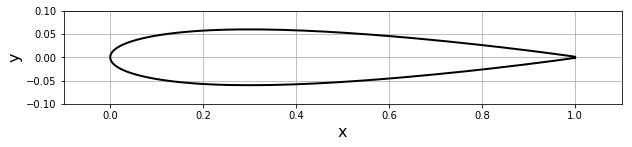

In [16]:
naca_filepath = os.path.join('naca0012.dat')
with open (naca_filepath, 'r') as file_name:
    x, y = np.loadtxt(file_name, dtype=float, delimiter='\t', unpack=True)
    
#plot geometry 
width = 10
py.figure(figsize=(width, width))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.plot(x, y, color='k', linestyle='-', linewidth=2)
py.axis('scaled', adjustable='box')
py.xlim(-0.1, 1.1)
py.ylim(-0.1, 0.1);

In [17]:
class Panel:
   
    def __init__(self, xa, ya, xb, yb):
        
        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= np.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

In [18]:
def define_panels(x, y, N=40):
    
    R = (x.max() - x.min()) / 2.0  # circle radius
    x_center = (x.max() + x.min()) / 2.0  # x-coordinate of circle center
    
    theta = np.linspace(0.0, 2.0 * np.pi, N + 1)  # array of angles
    x_circle = x_center + R * np.cos(theta)  # x-coordinates of circle
    
    x_ends = np.copy(x_circle)  # x-coordinate of panels end-points
    y_ends = np.empty_like(x_ends)  # y-coordinate of panels end-points
    
    # extend coordinates to consider closed surface
    x, y = np.append(x, x[0]), np.append(y, y[0])
    
    # compute y-coordinate of end-points by projection
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    # create panels
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels

In [19]:
# discretize geoemetry into panels
panels = define_panels(x, y, N=40)

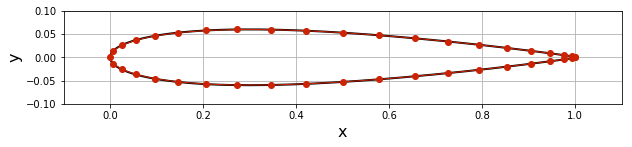

In [20]:
width = 10
py.figure(figsize=(width, width))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.plot(x, y, color='k', linestyle='-', linewidth=2)
py.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
py.axis('scaled', adjustable='box')
py.xlim(-0.1, 1.1)
py.ylim(-0.1, 0.1);

In [21]:
class Freestream:
    
    def __init__(self, u_inf=1.0, alpha=0.0):
        
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)

In [22]:
# define freestream conditions
freestream = Freestream(u_inf=1.0, alpha=4.0)

In [23]:
def integral(x, y, panel, dxdk, dydk):
    
    def integrand(s):
        return (((x - (panel.xa - np.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + np.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - np.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + np.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [24]:
#source contribution
def source_contribution_normal(panels):
    
    A = np.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    
    np.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    np.cos(panel_i.beta),
                                                    np.sin(panel_i.beta))
    return A

In [25]:
def vortex_contribution_normal(panels):
    
    A = np.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     np.sin(panel_i.beta),
                                                     -np.cos(panel_i.beta))
    return A

In [26]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

In [27]:
def kutta_condition(A_source, B_vortex):
   
    b = np.empty(A_source.shape[0] + 1, dtype=float)
    
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]

    b[-1] = - np.sum(A_source[0, :] + A_source[-1, :])
    return b

In [28]:
def build_singularity_matrix(A_source, B_vortex):
    
    A = np.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype=float)

    A[:-1, :-1] = A_source

    A[:-1, -1] = np.sum(B_vortex, axis=1)

    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

In [29]:
def build_freestream_rhs(panels, freestream):

    b = np.empty(panels.size + 1, dtype=float)

    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)

        b[-1] = -freestream.u_inf * (np.sin(freestream.alpha - panels[0].beta) +
                                 np.sin(freestream.alpha - panels[-1].beta) )
    return b

In [30]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)

In [31]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

## Finding Surface Pressure coef

In [32]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    
    A = np.empty((panels.size, panels.size + 1), dtype=float)
  
    A[:, :-1] = B_vortex
  
    A[:, -1] = -np.sum(A_source, axis=1)

    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = np.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [33]:
# tangential velocity at each panel center.
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

In [34]:
def compute_pressure_coefficient(panels, freestream):
    
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

In [35]:
# surface pressure coefficient
compute_pressure_coefficient(panels, freestream)

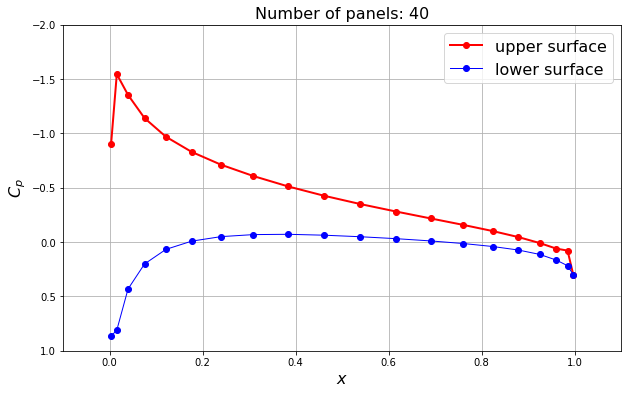

In [36]:
#plot sresult!

py.figure(figsize=(10, 6))
py.grid()
py.xlabel('$x$', fontsize=16)
py.ylabel('$C_p$', fontsize=16)
py.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'], label='upper surface', color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
py.plot([panel.xc for panel in panels if panel.loc == 'lower'], [panel.cp for panel in panels if panel.loc == 'lower'], label= 'lower surface', color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
py.legend(loc='best', prop={'size':16})
py.xlim(-0.1, 1.1)
py.ylim(1.0, -2.0)
py.title('Number of panels: {}'.format(panels.size), fontsize=16);

In [37]:
#check accuracy
#should == 0

accuracy = sum([panel.sigma * panel.length for panel in panels])
print('sum: {:0.6f}'.format(accuracy))

sum: 0.004606


## Lift

In [38]:
# compute the chord and lift coefficient
c = abs(max(panel.xa for panel in panels) -
        min(panel.xa for panel in panels))
cl = (gamma * sum(panel.length for panel in panels) /
      (0.5 * freestream.u_inf * c))
print('lift coefficient: CL = {:0.3f}'.format(cl))

lift coefficient: CL = 0.506


In [39]:
panels

array([<__main__.Panel object at 0x7f2173e975c0>,
       <__main__.Panel object at 0x7f2173ee34a8>], dtype=object)